In [1]:
# Importing in from .json file downloaded from Garmin

df = spark.read.option("multiline", "true").json("abfss://cdf6e060-d604-4869-9fdb-b4afea0ab27e@onelake.dfs.fabric.microsoft.com/1a5d0aaf-573b-472b-b0b3-48c8afeb4ff2/Files/DI-Connect-Fitness/sbayes38@gmail.com_0_summarizedActivities.json")
# df now is a Spark DataFrame containing JSON data from "abfss://cdf6e060-d604-4869-9fdb-b4afea0ab27e@onelake.dfs.fabric.microsoft.com/1a5d0aaf-573b-472b-b0b3-48c8afeb4ff2/Files/DI-Connect-Fitness/sbayes38@gmail.com_0_summarizedActivities.json".
display(df)

StatementMeta(, 2163ab98-0fd9-4231-99a9-945f85d730a0, 3, Finished, Available)

SynapseWidget(Synapse.DataFrame, c2ee565f-eadb-4868-a6dd-3c2d9139ee9a)

In [2]:
# import libraries required
from pyspark.sql.types import StructType, ArrayType, StructField
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import timedelta, datetime

StatementMeta(, 2163ab98-0fd9-4231-99a9-945f85d730a0, 4, Finished, Available)

**Exceeds size but only showing first 0 rows**... probably nested but let's just explore a bit.  
Show me a random selection of 5 rows

In [3]:
df.show(n=5)


StatementMeta(, 2163ab98-0fd9-4231-99a9-945f85d730a0, 5, Finished, Available)

+--------------------------+
|summarizedActivitiesExport|
+--------------------------+
|      [{null, 143928529...|
+--------------------------+



In [4]:
print(df.count())

StatementMeta(, 2163ab98-0fd9-4231-99a9-945f85d730a0, 6, Finished, Available)

1


In [5]:
df.printSchema()

StatementMeta(, 2163ab98-0fd9-4231-99a9-945f85d730a0, 7, Finished, Available)

root
 |-- summarizedActivitiesExport: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- activeSets: long (nullable = true)
 |    |    |-- activityId: long (nullable = true)
 |    |    |-- activityTrainingLoad: double (nullable = true)
 |    |    |-- activityType: string (nullable = true)
 |    |    |-- aerobicTrainingEffect: double (nullable = true)
 |    |    |-- aerobicTrainingEffectMessage: string (nullable = true)
 |    |    |-- anaerobicTrainingEffect: double (nullable = true)
 |    |    |-- anaerobicTrainingEffectMessage: string (nullable = true)
 |    |    |-- atpActivity: boolean (nullable = true)
 |    |    |-- autoCalcCalories: boolean (nullable = true)
 |    |    |-- avgDepth: double (nullable = true)
 |    |    |-- avgDoubleCadence: double (nullable = true)
 |    |    |-- avgFractionalCadence: double (nullable = true)
 |    |    |-- avgGradeAdjustedSpeed: double (nullable = true)
 |    |    |-- avgGroundContactTime: double (nullable = tr

ahhh so we need to explode the data.
Best practise would be to include the import at the top of the notebook but have left here to show you.

In [6]:
from pyspark.sql.functions import explode

# Explode the array to turn each element into a separate row
df_exploded = df.select(explode("summarizedActivitiesExport").alias("activity"))

StatementMeta(, 2163ab98-0fd9-4231-99a9-945f85d730a0, 8, Finished, Available)

This will **explode** the nesting and enable me to work out which columns I want - let's create a **function** to **iterate** through the schema fields and print them out.
This is similar to the _error catching_ and _for statement_ shown in the beginning, helped by ChatGPT

In [7]:
def get_column_paths(schema, parent_path=""):
    """
    Recursively generate dot-separated column paths for a given schema.
    :param schema: The schema of the DataFrame or a StructField.
    :param parent_path: The path leading to the current level in the schema (used for recursion).
    :return: A list of dot-separated column paths.
    """
    column_paths = []

    for field in schema.fields:
        current_path = f"{parent_path}.{field.name}" if parent_path else field.name
        
        # Check if the field is a StructType (nested)
        if isinstance(field.dataType, StructType):
            column_paths += get_column_paths(field.dataType, current_path)
        elif isinstance(field.dataType, ArrayType) and isinstance(field.dataType.elementType, StructType):
            # Handle arrays of structs by further expanding
            expanded_paths = get_column_paths(field.dataType.elementType, current_path)
            column_paths.extend(expanded_paths)
        else:
            column_paths.append(current_path)
    
    return column_paths


StatementMeta(, 2163ab98-0fd9-4231-99a9-945f85d730a0, 9, Finished, Available)

In [8]:
# df_exploded is the DataFrame after exploding 'summarizedActivitiesExport'
schema = df_exploded.schema

# Generate column paths using function
column_paths = get_column_paths(schema)

# Count the number of column paths
number_of_column_paths = len(column_paths)

print(f"Number of column paths: {number_of_column_paths}")

# Optionally, print some of the paths to verify
print(column_paths[:140])

StatementMeta(, 2163ab98-0fd9-4231-99a9-945f85d730a0, 10, Finished, Available)

Number of column paths: 143
['activity.activeSets', 'activity.activityId', 'activity.activityTrainingLoad', 'activity.activityType', 'activity.aerobicTrainingEffect', 'activity.aerobicTrainingEffectMessage', 'activity.anaerobicTrainingEffect', 'activity.anaerobicTrainingEffectMessage', 'activity.atpActivity', 'activity.autoCalcCalories', 'activity.avgDepth', 'activity.avgDoubleCadence', 'activity.avgFractionalCadence', 'activity.avgGradeAdjustedSpeed', 'activity.avgGroundContactTime', 'activity.avgHr', 'activity.avgPower', 'activity.avgRespirationRate', 'activity.avgRunCadence', 'activity.avgSpeed', 'activity.avgStress', 'activity.avgStrideLength', 'activity.avgStrokeDistance', 'activity.avgSwimCadence', 'activity.avgSwolf', 'activity.avgVerticalOscillation', 'activity.avgVerticalRatio', 'activity.avgVerticalSpeed', 'activity.beginTimestamp', 'activity.bmrCalories', 'activity.bottomTime', 'activity.calories', 'activity.caloriesConsumed', 'activity.decoDive', 'activity.description', 'ac

There's 143. I don't want that many and I definitely don't want to type them out...
I don't want the columns for splits or sets so let's exclude them.

In [9]:
def get_column_paths(schema, parent_path="", exclude_paths=['splits', 'sets']):
    """
    Recursively generate dot-separated column paths for a given schema, excluding specified paths.
    :param schema: The schema of the DataFrame or a StructField.
    :param parent_path: The path leading to the current level in the schema (used for recursion).
    :param exclude_paths: A list of path keywords to exclude.
    :return: A list of dot-separated column paths.
    """
    column_paths = []

    for field in schema.fields:
        current_path = f"{parent_path}.{field.name}" if parent_path else field.name

        # Check if the current path contains any excluded keywords
        if any(exclude_keyword in current_path for exclude_keyword in exclude_paths):
            continue  # Skip adding this path and its children

        # Check if the field is a StructType (nested)
        if isinstance(field.dataType, StructType):
            column_paths += get_column_paths(field.dataType, current_path, exclude_paths)
        elif isinstance(field.dataType, ArrayType) and isinstance(field.dataType.elementType, StructType):
            # Handle arrays of structs by further expanding, unless excluded
            expanded_paths = get_column_paths(field.dataType.elementType, current_path, exclude_paths)
            column_paths.extend(expanded_paths)
        else:
            column_paths.append(current_path)
    
    return column_paths

StatementMeta(, 2163ab98-0fd9-4231-99a9-945f85d730a0, 11, Finished, Available)

In [10]:
# Generate column paths excluding 'splits'
column_paths = get_column_paths(df_exploded.schema, exclude_paths=['splits', 'sets'])

# Count the number of column paths to verify the exclusion
number_of_column_paths = len(column_paths)
print(f"Number of column paths after excluding 'splits': {number_of_column_paths}")

# Optionally, show some of the paths to confirm 'splits' are excluded
print(column_paths[:120])  

StatementMeta(, 2163ab98-0fd9-4231-99a9-945f85d730a0, 12, Finished, Available)

Number of column paths after excluding 'splits': 123
['activity.activeSets', 'activity.activityId', 'activity.activityTrainingLoad', 'activity.activityType', 'activity.aerobicTrainingEffect', 'activity.aerobicTrainingEffectMessage', 'activity.anaerobicTrainingEffect', 'activity.anaerobicTrainingEffectMessage', 'activity.atpActivity', 'activity.autoCalcCalories', 'activity.avgDepth', 'activity.avgDoubleCadence', 'activity.avgFractionalCadence', 'activity.avgGradeAdjustedSpeed', 'activity.avgGroundContactTime', 'activity.avgHr', 'activity.avgPower', 'activity.avgRespirationRate', 'activity.avgRunCadence', 'activity.avgSpeed', 'activity.avgStress', 'activity.avgStrideLength', 'activity.avgStrokeDistance', 'activity.avgSwimCadence', 'activity.avgSwolf', 'activity.avgVerticalOscillation', 'activity.avgVerticalRatio', 'activity.avgVerticalSpeed', 'activity.beginTimestamp', 'activity.bmrCalories', 'activity.bottomTime', 'activity.calories', 'activity.caloriesConsumed', 'activity.decoDive', 'a

Still too many... let's reassess and think... what do I want to achieve....
I want to focus on my goal and stop going down this rabbit hole.
What are the key measures to allow me to analyse my running and see if I am likely to achieve my goal?

In [11]:
# These are the relevant columns
selected_columns = [
    'activity.avgSpeed',
    'activity.beginTimestamp',
    'activity.distance',
    'activity.duration',
    'activity.avgHr',
    'activity.calories',
    'activity.elevationGain',
    'activity.elevationLoss',
    'activity.avgRunCadence',
    'activity.activityType',
    'activity.vO2MaxValue',
    'activity.aerobicTrainingEffect',
    'activity.anaerobicTrainingEffect',
    'activity.trainingEffectLabel'
]

StatementMeta(, 2163ab98-0fd9-4231-99a9-945f85d730a0, 13, Finished, Available)

We will use the list to **filter** our dataframe

In [12]:
df_selected = df_exploded.select(selected_columns)
df_selected.head()

StatementMeta(, 2163ab98-0fd9-4231-99a9-945f85d730a0, 14, Finished, Available)

Row(avgSpeed=0.28010001182556155, beginTimestamp=1710353230000, distance=806814.990234375, duration=2880512.939453125, avgHr=140.0, calories=2178.8104, elevationGain=8415.000000596046, elevationLoss=7846.999999880791, avgRunCadence=85.0, activityType='running', vO2MaxValue=48.0, aerobicTrainingEffect=3.5, anaerobicTrainingEffect=0.0, trainingEffectLabel='TEMPO')

In [13]:
pandas_df = df_selected.toPandas()

StatementMeta(, 2163ab98-0fd9-4231-99a9-945f85d730a0, 15, Finished, Available)

In [14]:
pandas_df.info()

StatementMeta(, 2163ab98-0fd9-4231-99a9-945f85d730a0, 16, Finished, Available)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 444 entries, 0 to 443
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   avgSpeed                 346 non-null    float64
 1   beginTimestamp           444 non-null    int64  
 2   distance                 331 non-null    float64
 3   duration                 444 non-null    float64
 4   avgHr                    402 non-null    float64
 5   calories                 444 non-null    float64
 6   elevationGain            250 non-null    float64
 7   elevationLoss            250 non-null    float64
 8   avgRunCadence            250 non-null    float64
 9   activityType             444 non-null    object 
 10  vO2MaxValue              242 non-null    float64
 11  aerobicTrainingEffect    402 non-null    float64
 12  anaerobicTrainingEffect  402 non-null    float64
 13  trainingEffectLabel      402 non-null    object 
dtypes: float64(11), int64(1), 

In [15]:
# Now, count the rows for each type of running activity
running_counts = pandas_df['activityType'].value_counts()

# Display the counts
print(running_counts)

StatementMeta(, 2163ab98-0fd9-4231-99a9-945f85d730a0, 17, Finished, Available)

activityType
running                226
yoga                   143
open_water_swimming     42
walking                 24
strength_training        7
street_running           1
hiit                     1
Name: count, dtype: int64


In [16]:
running_activities = ['running', 'street_running']
running_df = pandas_df[pandas_df['activityType'].isin(running_activities)]

StatementMeta(, 2163ab98-0fd9-4231-99a9-945f85d730a0, 18, Finished, Available)

In [17]:
# Count the number of missing values in each column
missing_values_count = running_df.isnull().sum()

# Print the count of missing values for each column
print(missing_values_count)

StatementMeta(, 2163ab98-0fd9-4231-99a9-945f85d730a0, 19, Finished, Available)

avgSpeed                   0
beginTimestamp             0
distance                   0
duration                   0
avgHr                      1
calories                   0
elevationGain              1
elevationLoss              1
avgRunCadence              1
activityType               0
vO2MaxValue                8
aerobicTrainingEffect      1
anaerobicTrainingEffect    1
trainingEffectLabel        1
dtype: int64


In [18]:
running_df.describe()

StatementMeta(, 2163ab98-0fd9-4231-99a9-945f85d730a0, 20, Finished, Available)

,avgSpeed,beginTimestamp,distance,duration,avgHr,calories,elevationGain,elevationLoss,avgRunCadence,vO2MaxValue,aerobicTrainingEffect,anaerobicTrainingEffect
count,227.000000,2.270000e+02,2.270000e+02,2.270000e+02,226.000000,227.000000,226.000000,226.000000,226.000000,219.000000,226.000000,226.000000
mean,0.258655,1.694430e+12,9.804811e+05,3.772922e+06,139.991150,2749.372991,12705.088495,12236.389381,80.969027,43.675799,3.570796,0.419027
std,0.025448,8.641431e+09,7.418842e+05,2.910862e+06,9.851335,2116.815999,9538.431236,9552.414500,6.855584,3.876524,0.859010,0.793832
min,0.067800,1.679644e+12,4.180400e+04,1.797680e+05,88.000000,0.000000,0.000000,0.000000,17.000000,33.000000,0.800000,0.000000
25%,0.248100,1.686341e+12,5.354018e+05,2.106236e+06,135.250000,1512.597220,7636.500000,7186.250000,80.250000,41.000000,3.125000,0.000000
50%,0.259400,1.694324e+12,8.444070e+05,3.228145e+06,140.000000,2371.551320,12123.999999,11748.500000,82.000000,44.000000,3.500000,0.000000
75%,0.271300,1.701978e+12,1.141473e+06,4.277241e+06,145.000000,3140.419990,16211.750000,15632.249999,84.000000,47.000000,4.100000,0.400000
max,0.316400,1.710353e+12,4.794723e+06,2.465203e+07,177.000000,15796.375400,99508.000000,99031.999999,87.000000,48.000000,5.000000,3.500000


In [19]:
# convert to date time
running_df.loc[:, 'beginTimestamp'] = pd.to_datetime(running_df['beginTimestamp'], unit='ms')

StatementMeta(, 2163ab98-0fd9-4231-99a9-945f85d730a0, 21, Finished, Available)

In [20]:
# Display the first few rows to check the dates
print(running_df.head())

# Check the minimum and maximum dates to understand the time range
print("Minimum date:", running_df.index.min())
print("Maximum date:", running_df.index.max())

StatementMeta(, 2163ab98-0fd9-4231-99a9-945f85d730a0, 22, Finished, Available)

    avgSpeed      beginTimestamp      distance      duration  avgHr  \
0     0.2801 2024-03-13 18:07:10  8.068150e+05  2.880513e+06  140.0   
3     0.2579 2024-03-11 18:09:30  1.176096e+06  4.559803e+06  141.0   
7     0.2505 2024-03-08 17:45:41  2.634845e+06  1.052043e+07  142.0   
8     0.2916 2024-03-07 18:05:52  8.989180e+05  3.082481e+06  166.0   
11    0.2869 2024-03-04 18:06:24  1.091484e+06  3.804463e+06  156.0   

      calories  elevationGain  elevationLoss  avgRunCadence activityType  \
0   2178.81040    8415.000001    7847.000000           85.0      running   
3   3272.40562   21850.999999   22218.000001           79.0      running   
7   7424.71544   30412.000000   34782.999998           83.0      running   
8   2673.23276   14443.000001   13710.000000           86.0      running   
11  3129.94494   11789.999998   10480.000001           87.0      running   

    vO2MaxValue  aerobicTrainingEffect  anaerobicTrainingEffect  \
0          48.0                    3.5           

In [21]:
# Set 'activity.beginTimestamp' as the index
running_df.set_index('beginTimestamp', inplace=True)

StatementMeta(, 2163ab98-0fd9-4231-99a9-945f85d730a0, 23, Finished, Available)

In [22]:
running_df.sort_index(inplace=True)

StatementMeta(, 2163ab98-0fd9-4231-99a9-945f85d730a0, 24, Finished, Available)

/tmp/ipykernel_5633/4207850411.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  running_df.sort_index(inplace=True)


A **view** in Pandas is a reference to the original data, meaning that any changes made to the view will affect the original DataFrame or Series.
Views are often created as a result of indexing operations that do not copy the underlying data.
When you perform operations that return a view, you're essentially looking at the same data through a different lens. This is memory efficient but requires caution to avoid unintentional modifications to the original data.  

A **slice** refers to a segment of the DataFrame or Series selected from the whole.
In Pandas, slices can sometimes create a view and other times create a copy, depending on the context. For example, slicing rows generally returns a view, whereas slicing columns (e.g., selecting or assigning a subset of columns) often results in a copy.
The ambiguity of whether a slice creates a view or a copy is a source of confusion. To explicitly control this behaviour, Pandas provides the .loc, .iloc, and .copy() methods to ensure you know whether you're working with a view or a copy.

In [23]:
# Check the type of the index
print(type(running_df.index))

# Display the first few rows of the DataFrame to see the index along with the data
print(running_df.head())

StatementMeta(, 2163ab98-0fd9-4231-99a9-945f85d730a0, 25, Finished, Available)

<class 'pandas.core.indexes.datetimes.DatetimeIndex'>
                     avgSpeed       distance      duration  avgHr    calories  \
beginTimestamp                                                                  
2023-03-24 07:48:37  0.228700  611535.986328  2.674297e+06  144.0  1910.64912   
2023-03-31 07:04:14  0.174700  624118.994141  3.572414e+06  135.0  1956.73934   
2023-04-01 05:32:51  0.270526  535911.552000  1.981000e+06   88.0     0.00000   
2023-04-03 17:10:16  0.234000  811208.984375  3.466307e+06  147.0  2421.83156   
2023-04-05 07:06:01  0.199200  359397.998047  1.804637e+06  133.0  1060.07506   

                     elevationGain  elevationLoss  avgRunCadence activityType  \
beginTimestamp                                                                  
2023-03-24 07:48:37    9911.000000    9177.999997           81.0      running   
2023-03-31 07:04:14   14323.000000   14569.999999           58.0      running   
2023-04-01 05:32:51       0.000000       0.000000     

StatementMeta(, 2163ab98-0fd9-4231-99a9-945f85d730a0, 26, Finished, Available)

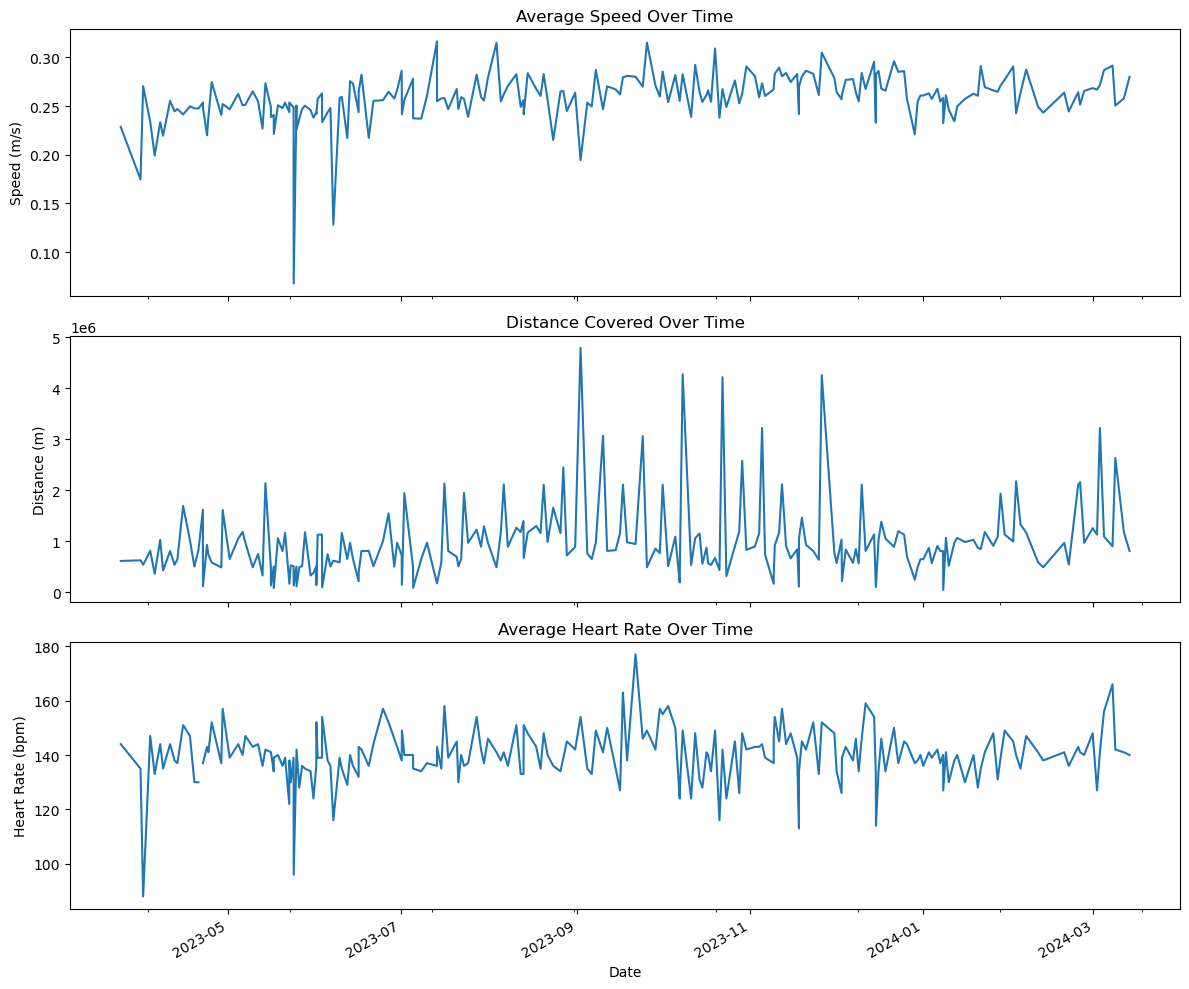

In [24]:
# Create a figure with subplots for each metric of interest
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 10), sharex=True)

# Plot average speed
running_df['avgSpeed'].plot(ax=axes[0], title='Average Speed Over Time')
axes[0].set_ylabel('Speed (m/s)')

# Plot distance
running_df['distance'].plot(ax=axes[1], title='Distance Covered Over Time')
axes[1].set_ylabel('Distance (m)')

# Plot average heart rate
running_df['avgHr'].plot(ax=axes[2], title='Average Heart Rate Over Time')
axes[2].set_ylabel('Heart Rate (bpm)')

# Set the x-label for the bottom plot
axes[2].set_xlabel('Date')

plt.tight_layout()
plt.show()


I ran Florence marathon on 26th November 2023 and achieved a finish time of 3 hours 52 mins 53 seconds.  

I am due to run Vienna marathon on 21st April 2024 and would like to better that time.  

What I'm particularly interested in is where I am now fitness and health wise with about 4 weeks to go compared to where I was 4 weeks to go before Florence.  

I'd like to do an analysis based on each of the columns we selected with a view to being at the same level of fitness or above ready for Vienna.  

1. Identify Key Dates
Florence Marathon Date: 26th November 2023
8 Weeks Prior to Florence: Calculate this date to focus on the comparison period.
Vienna Marathon Date: 21st April 2024
Current Date for Comparison: Assuming today's date is to assess the "4 weeks to go" mark for Vienna.

florence_marathon_date = pd.Timestamp('2023-11-26')
florence_comparison_date = florence_marathon_date - pd.Timedelta(weeks=4)

vienna_marathon_date = pd.Timestamp('2024-04-21')
current_date = vienna_marathon_date - pd.Timedelta(weeks=4)  # Adjust based on the actual current date

In [25]:
# Assuming running_df is your DataFrame
florence_marathon_date = pd.Timestamp('2023-11-26')
vienna_marathon_date = pd.Timestamp('2024-04-21')
current_date = pd.Timestamp(datetime.now())

# Calculate weeks to marathon for Florence
running_df['weeks_to_florence'] = (florence_marathon_date - running_df.index) / np.timedelta64(1, 'W')

# Calculate weeks to marathon for Vienna
running_df['weeks_to_vienna'] = (vienna_marathon_date - running_df.index) / np.timedelta64(1, 'W')

# Filter data for the last 10 months (~40 weeks) before each marathon
florence_data = running_df[(running_df['weeks_to_florence'] <= 40) & (running_df['weeks_to_florence'] >= 0)].copy()
vienna_data = running_df[(running_df['weeks_to_vienna'] <= 40) & (running_df['weeks_to_vienna'] >= 0)].copy()

StatementMeta(, 2163ab98-0fd9-4231-99a9-945f85d730a0, 27, Finished, Available)

/tmp/ipykernel_5633/650581876.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  running_df['weeks_to_florence'] = (florence_marathon_date - running_df.index) / np.timedelta64(1, 'W')
/tmp/ipykernel_5633/650581876.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  running_df['weeks_to_vienna'] = (vienna_marathon_date - running_df.index) / np.timedelta64(1, 'W')


StatementMeta(, 2163ab98-0fd9-4231-99a9-945f85d730a0, 28, Finished, Available)

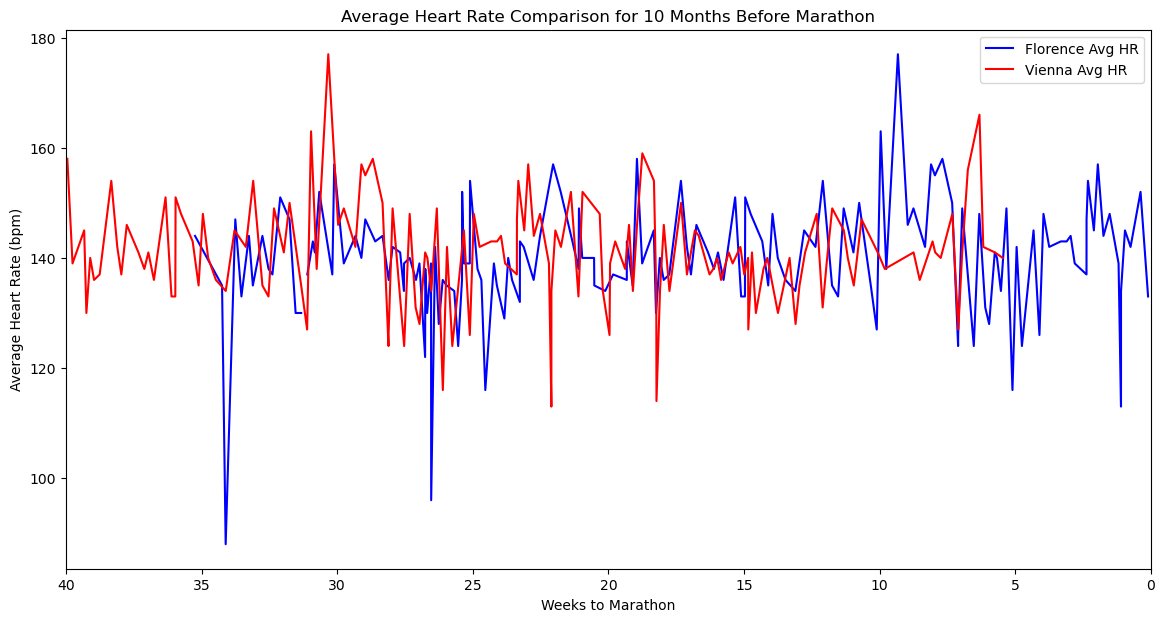

In [26]:
plt.figure(figsize=(14, 7))

# Plotting Florence data
plt.plot(florence_data['weeks_to_florence'], florence_data['avgHr'], label='Florence Avg HR', color='blue')

# Plotting Vienna data
plt.plot(vienna_data['weeks_to_vienna'], vienna_data['avgHr'], label='Vienna Avg HR', color='red')

plt.title('Average Heart Rate Comparison for 10 Months Before Marathon')
plt.xlabel('Weeks to Marathon')
plt.ylabel('Average Heart Rate (bpm)')
plt.legend()
plt.gca().invert_xaxis()  # Invert x-axis to show countdown to marathon
plt.xlim(40, 0)  # Set x-axis limits to show only the last 10 months leading to the marathon
plt.show()


StatementMeta(, 2163ab98-0fd9-4231-99a9-945f85d730a0, 29, Finished, Available)

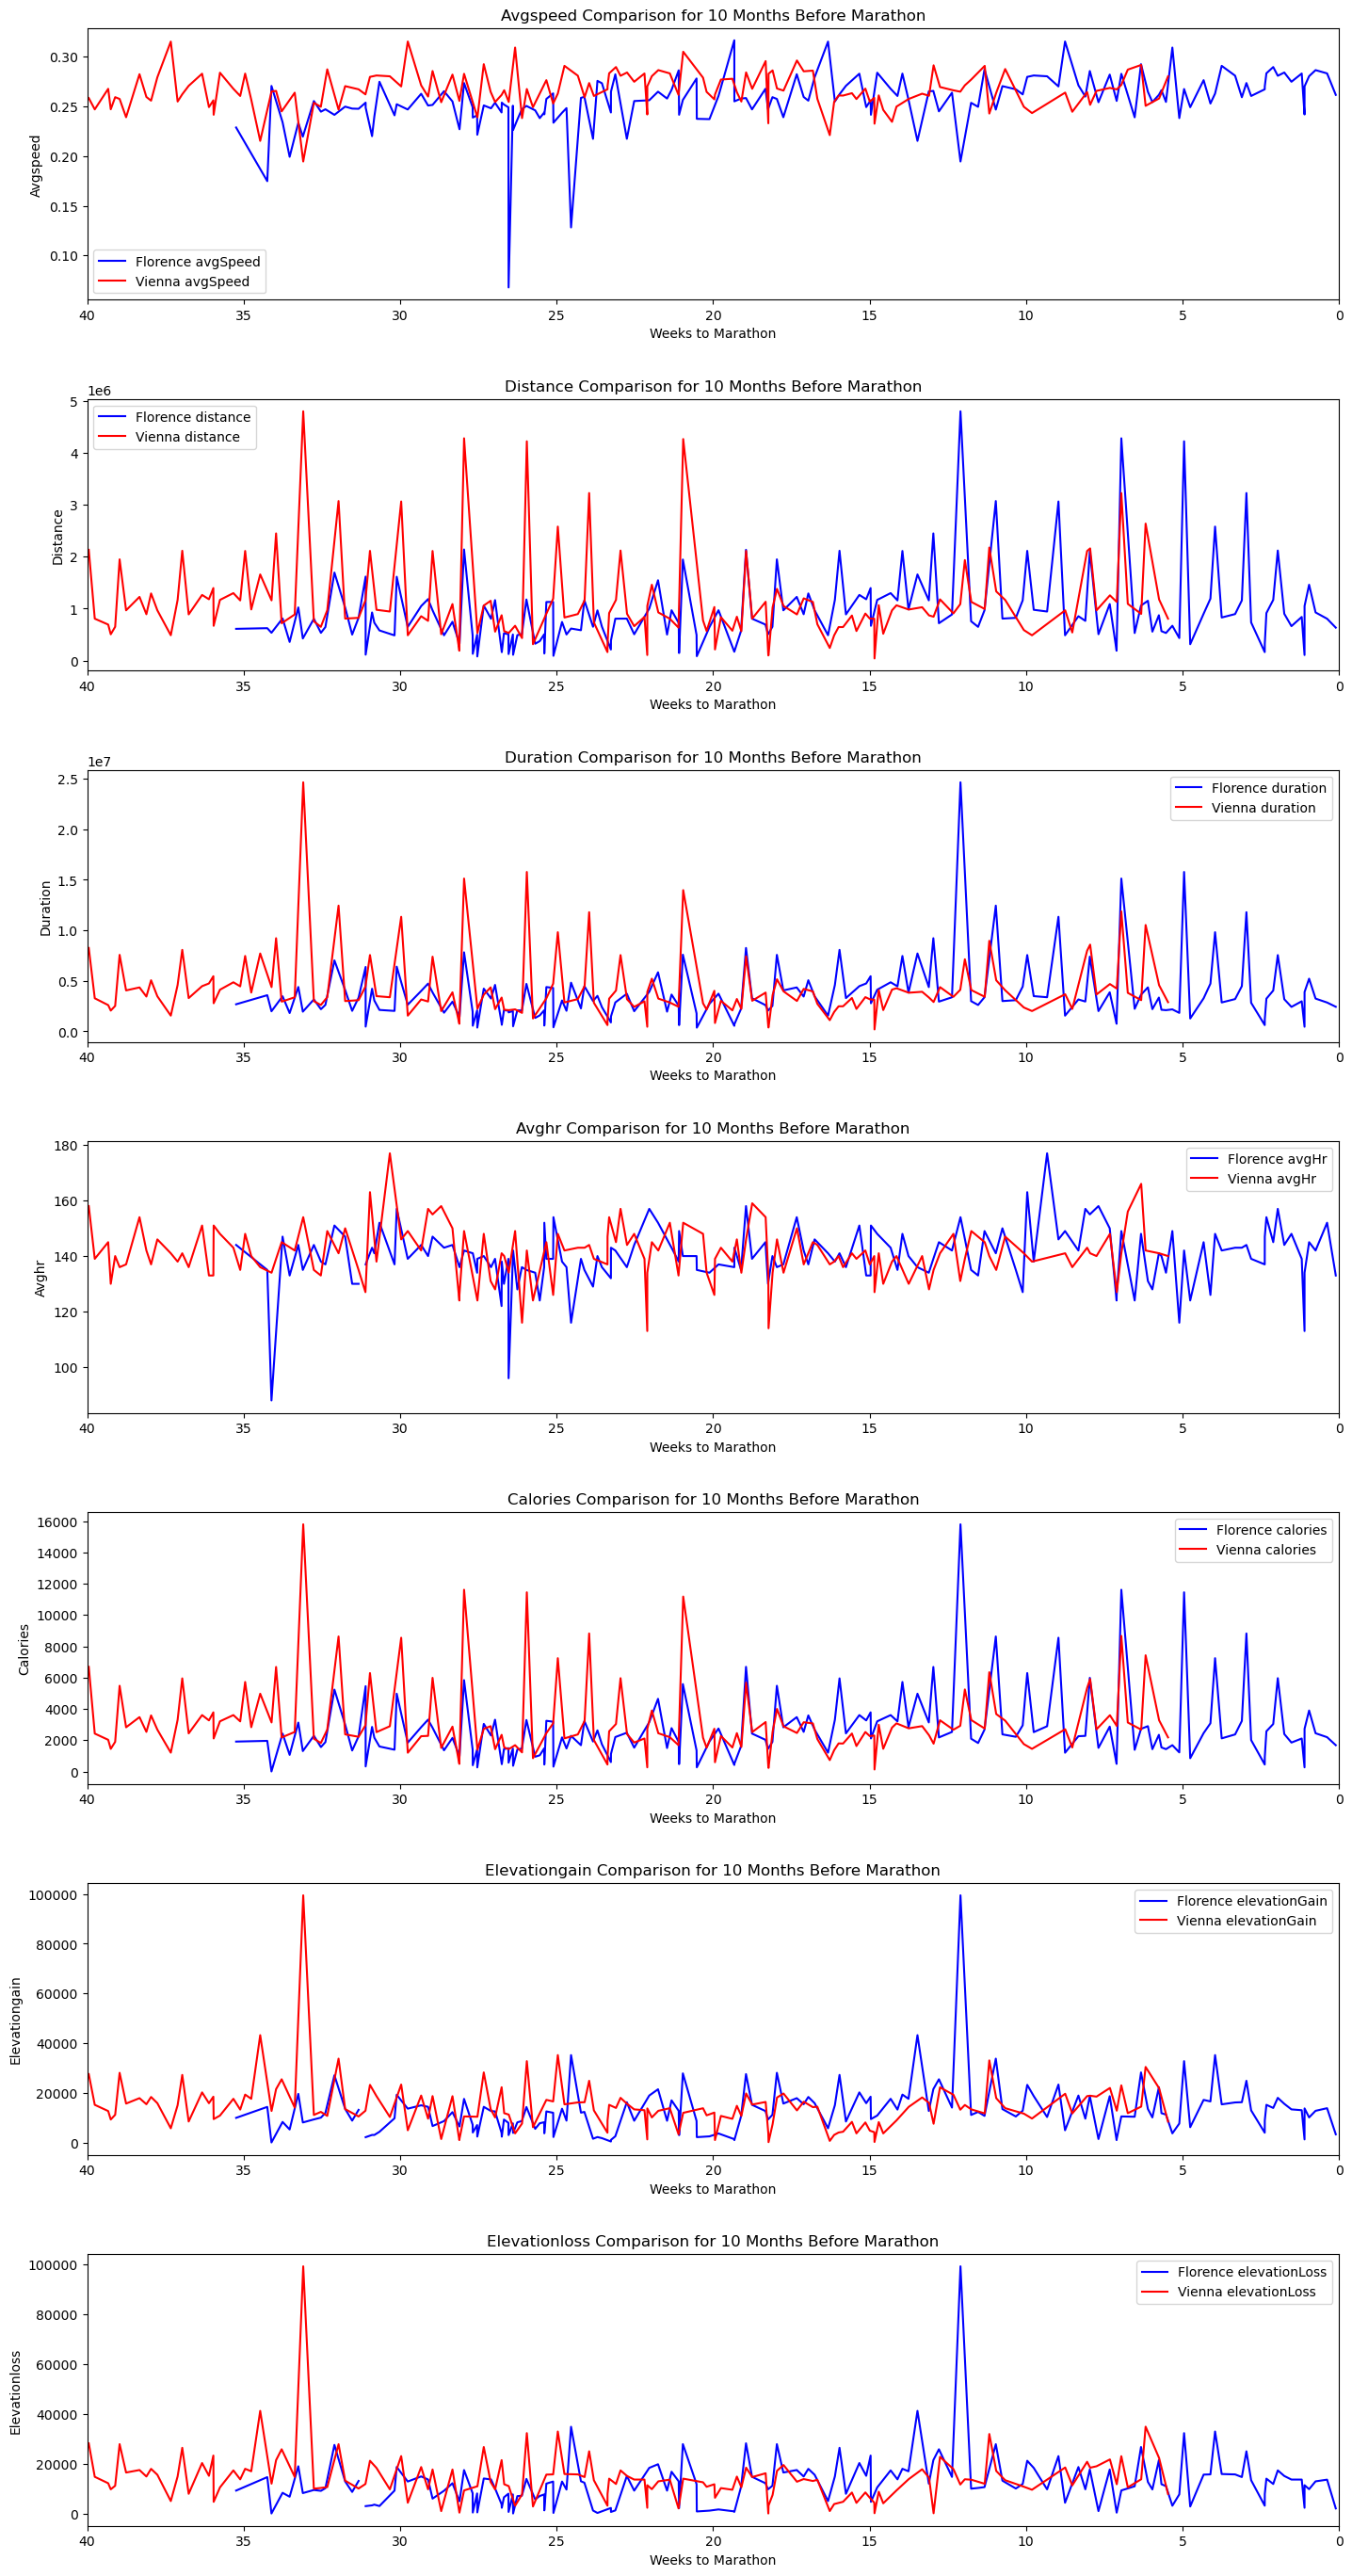

In [27]:
# Define the metrics you're interested in
metrics = ['avgSpeed', 'distance', 'duration', 'avgHr', 'calories', 'elevationGain', 'elevationLoss']

# Increase the figure size
plt.figure(figsize=(15, 4 * len(metrics)))  # Adjust width and height as needed

for i, metric in enumerate(metrics):
    ax = plt.subplot(len(metrics), 1, i + 1)
    ax.plot(florence_data['weeks_to_florence'], florence_data[metric], label=f'Florence {metric}', color='blue')
    ax.plot(vienna_data['weeks_to_vienna'], vienna_data[metric], label=f'Vienna {metric}', color='red')
    ax.set_title(f'{metric.capitalize()} Comparison for 10 Months Before Marathon')
    ax.set_xlabel('Weeks to Marathon')
    ax.set_ylabel(metric.capitalize())
    ax.legend()
    ax.invert_xaxis()  # Invert x-axis to show countdown to marathon
    ax.set_xlim(40, 0)  # Ensure the plot only shows the last 10 months leading to the marathon

plt.tight_layout(pad=3.0)  # Adjust layout spacing to prevent overlap
plt.show()
